In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

## Utils

In [2]:
def open_images(path : str, color_scale = cv.COLOR_BGR2RGB) -> list:
    """
    Opens all images from a directory.
    Args:
        path: str -> file path of the directory
    Returns:
        list -> list of image matrices. 
    """
    import os 
    temp = []
    if path.endswith("/"):
        items = os.listdir(path)
        print(items)
        for p in items:
            
            if (p.endswith("png") | p.endswith("pg")):

                img = cv.cvtColor(cv.imread(path + p), color_scale)
                temp.append(img)
        return temp
    if color_scale is cv.IMREAD_GRAYSCALE:
        return cv.imread(path, color_scale)
    return cv.cvtColor(cv.imread(path), color_scale)

def show_image_list(images : list, nrows = 1, figsize = (12,8), cmap :list = ['gray'], titles = [""]):
    ncols = len(images)
    _, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)

    axes = axes.ravel()

    for i in range(len(axes)):
       axes[i].set_axis_off()
       if (len(cmap)>1):
           axes[i].imshow(images[i], cmap=cmap[i])
           if (len(titles)>0):
               axes[i].set_title(titles[i])
       else:
           axes[i].imshow(images[i], cmap=cmap[0])
           if (len(titles)>0):
               axes[i].set_title(titles[i])

def show_plots(plots, nrows = 1,figsize=(12,8)):
    ncols = len(plots)
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)

    axes = axes.ravel()

    for i in range(len(axes)):
       axes[i].plot(plots[i])

In [3]:
coca_logo,coca_logo_1,coca_logo_2,coca_multi,retro_1,retro_2,logo_1 = open_images('./images/')

['COCA-COLA-LOGO.jpg', 'coca_logo_1.png', 'coca_logo_2.png', 'coca_multi.png', 'coca_retro_1.png', 'coca_retro_2.png', 'logo_1.png']


In [4]:
pattern = open_images('./template/pattern.png')

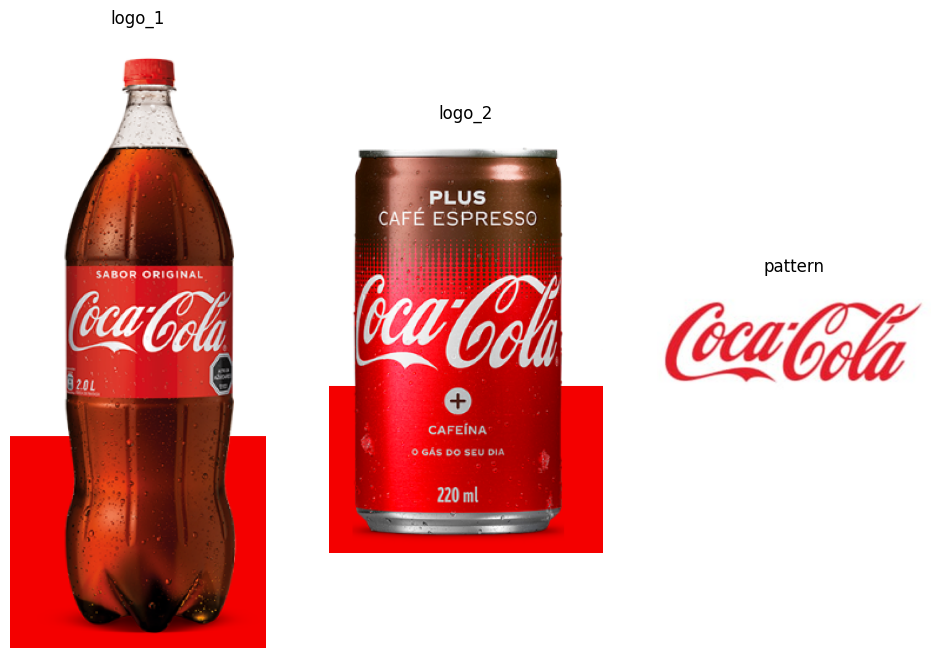

In [5]:
show_image_list([coca_logo_1,coca_logo_2,pattern],titles=['logo_1','logo_2','pattern'])

In [6]:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

## Template matcher

In [7]:
def preprocess(img, ksize = (3,3), sigma = None, thresh_1 = 100, thresh_2 = 255):
    """
    template matcher preprocessor, applies a grayscale transformation, then applies a blur for noise reduction, finally
    it applies a thresholded canny edge detector.

    Args : 
        img : target image
        ksize : kernel size (blur)
        sigma (optional): sigma when using gaussian blur
        thresh_1 : canny threshold
        thresh_2  : canny threshold
    """
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    if sigma != None:
        img = cv.GaussianBlur(gray,ksize=ksize,sigmaX=sigma, sigmaY=sigma)
    else:
        img = cv.blur(gray,ksize=ksize)
    img = cv.Canny(img,thresh_1, thresh_2)
    return img

In [8]:
def custom_template_matcher(img, template,methods = 'cv.TM_CCOEFF_NORMED', scales = np.linspace(0.5,2,30), thresholds = (220,300), figsize = (10,8)):
    """
    Multi-scale template matcher, plots the bounding-box of the match.
    Args:
        img : target image
        template: template image
        method : opencv's TemplateMatchMode
        scales : list of scales to test, default np.linspace(0.5,2,30)

    Returns 
        list of matches 
    """

    matches = []
    found = None
    best_method = None
    for scale in scales:
        try:
            resized_template = cv.resize(template,None,fx = scale , fy = scale)
            w, h = resized_template.shape[::-1]
            img_copy = img.copy()
            img_processed = preprocess(img_copy, (5,5), sigma=2, thresh_1= thresholds[0], thresh_2=thresholds[1])
            if np.greater(np.array(resized_template.shape),np.array(img_processed.shape))[1]:
                raise BaseException('template shape cannot be greater than img')
            

            method = eval(methods)
            match = cv.matchTemplate(img_processed,resized_template, method)
            minval, maxVal, min_loc, max_loc = cv.minMaxLoc(match)

            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                top_left = min_loc
            else:
                top_left = max_loc
            if found is None or ((maxVal+minval > top) and (minval > topmin)):

                topmin = minval
                top = maxVal + minval
                bottom_right = (top_left[0] + w, top_left[1] + h)
                found = (maxVal,minval,top_left, bottom_right,scale)
                best_method = methods
                matches.append({'max':maxVal,'min':minval})
        except:
            continue
    
           


    cv.rectangle(img_copy,found[2], found[3], (0,255,0), 2)
    plt.figure(figsize=figsize)
    

    plt.subplot(121),plt.imshow(match,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    

    plt.subplot(122),plt.imshow(img_copy)
    plt.title(f'Detected Point with scale{found[4]}'), plt.xticks([]), plt.yticks([])
    
    plt.suptitle(best_method)
    plt.show()
    return matches


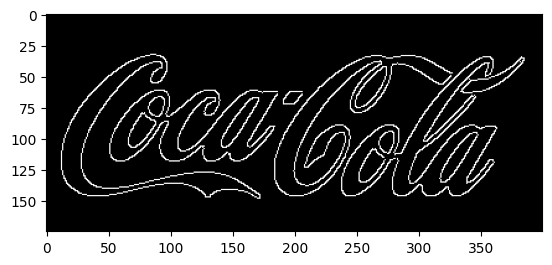

In [9]:
pattern_canny = preprocess(pattern, sigma = 1)
plt.imshow(pattern_canny, cmap='gray')

In [10]:
methods

['cv.TM_CCOEFF',
 'cv.TM_CCOEFF_NORMED',
 'cv.TM_CCORR',
 'cv.TM_CCORR_NORMED',
 'cv.TM_SQDIFF',
 'cv.TM_SQDIFF_NORMED']

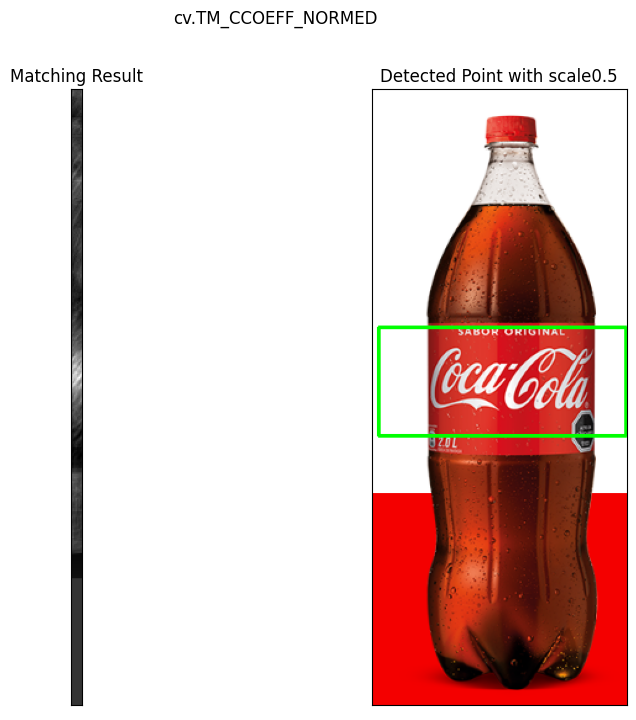

[{'max': 0.12960784137248993, 'min': -0.0326167494058609}]

In [11]:
scales = np.linspace(0.2,1,20)
custom_template_matcher(coca_logo_1,pattern_canny)

### plotting preprocessed images

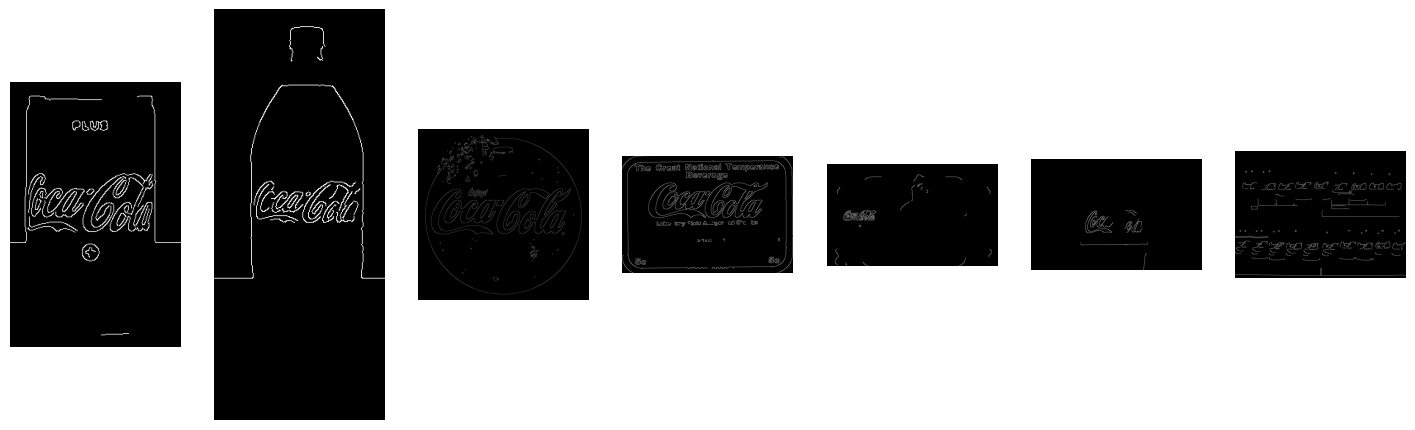

In [12]:
cann_2 = preprocess(coca_logo_2, (5,5), sigma=2, thresh_1= 200, thresh_2=400)
cann_3 = preprocess(coca_logo_1, (5,5), sigma=2, thresh_1= 200, thresh_2=400)
cann_4 = preprocess(coca_logo, (5,5), sigma=2, thresh_1= 200, thresh_2=400)
cann_5 = preprocess(coca_multi, (5,5), sigma=2, thresh_1= 200, thresh_2=400)
cann_6 = preprocess(retro_1, (5,5), sigma=2, thresh_1= 200, thresh_2=400)
cann_7 = preprocess(retro_2, (5,5), sigma=2, thresh_1= 200, thresh_2=400) 
cann_8 = preprocess(logo_1, (5,5), sigma=2, thresh_1= 200, thresh_2=400)   
show_image_list([cann_2,cann_3,cann_4,cann_6,cann_7,cann_8,cann_5],figsize=(18,12), titles = [])

## Parte I
Obtener una detección del logo en cada imagen sin falsos positivos


In [13]:
logos = [coca_logo,coca_logo_1,coca_logo_2,retro_1,retro_2,logo_1]

### testeando todas las imagenes con la mismas escalas

Debido a que las imagenes varian considerablemente de tamaño, probemos con una muestra de tamaño 20 que va de valores de 0.3 a 3 como valores de escalamiento del template,
sin embargo al momento de aplicar el template matcher, lo recomendado es utilizar un linspace unico para cada imagen, veamos ejemplos

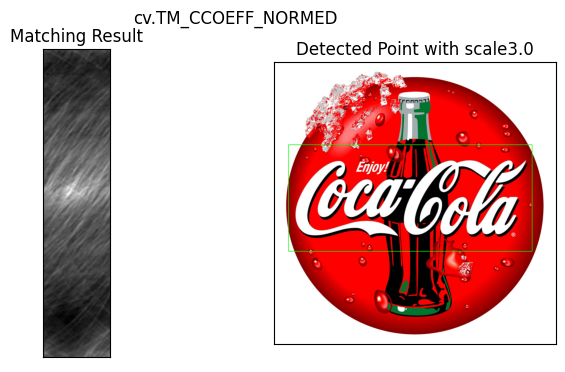

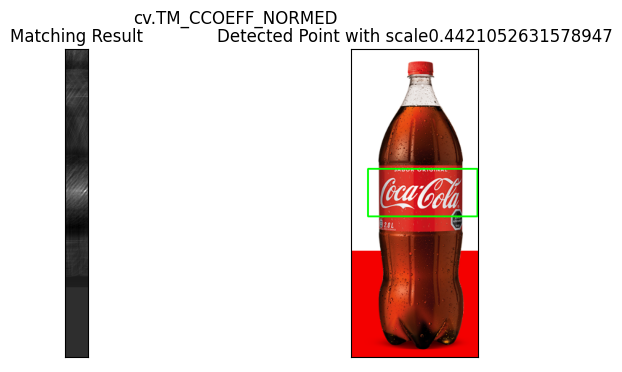

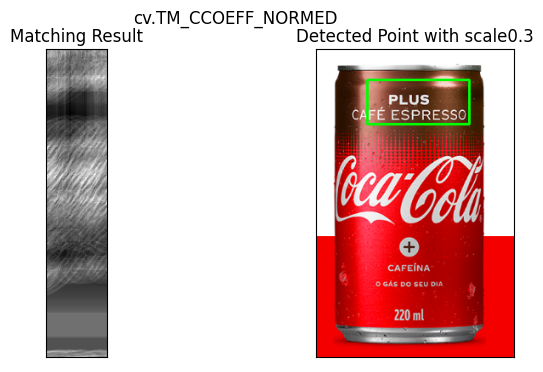

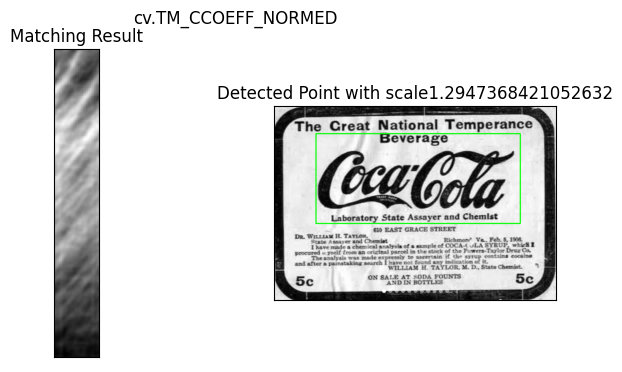

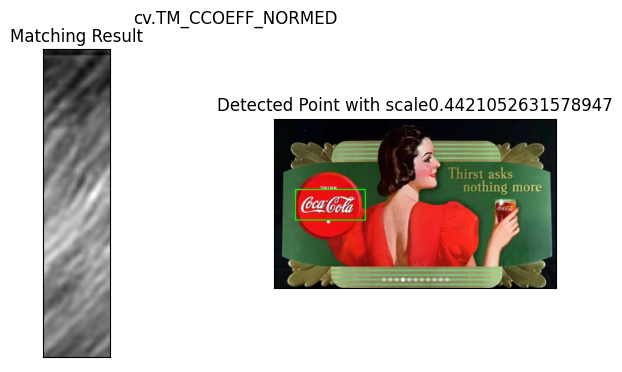

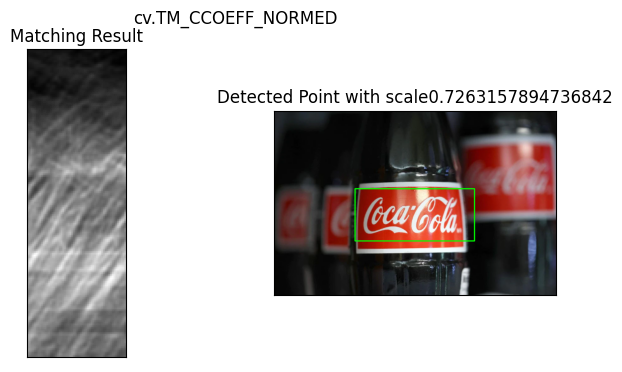

In [14]:
# mismo linspace para todos
for logo in logos:
    custom_template_matcher(logo,pattern_canny,'cv.TM_CCOEFF_NORMED',thresholds=(200,400),scales= np.linspace(0.3,3,20), figsize=(8,4))

En este caso la imagen coca_logo_2 no fue correctamente detectada, probemos con otro espacio de escalamiento, el unico cambio es que la escala maxima es de 2

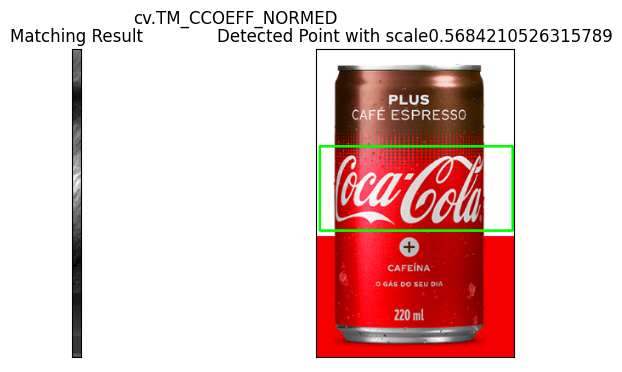

In [15]:
matches = custom_template_matcher(coca_logo_2,pattern_canny,'cv.TM_CCOEFF_NORMED',thresholds=(200,400), scales= np.linspace(0.3,2,20), figsize=(8,4))

## Parte II
(4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1

In [16]:
def custom_template_matcher_multiple(img, template,threshold = 0.7,methods = 'cv.TM_CCOEFF_NORMED', scales = np.linspace(0.5,2,30), thresholds = (220,300), figsize = (10,8)):
    """
    Multi-scale template matcher, plots the bounding-box of the match.
    Args:
        img : target image
        template: template image
        method : opencv's TemplateMatchMode
        scales : list of scales to test, default np.linspace(0.5,2,30)

    Returns 
        list of matches 
    """
    found = None
    best_method = None
    for scale in scales:
        try:
            resized_template = cv.resize(template,None,fx = scale , fy = scale)
            w, h = resized_template.shape[::-1]
            img_copy = img.copy()
            img_processed = preprocess(img_copy, (5,5), sigma=2, thresh_1= thresholds[0], thresh_2=thresholds[1])
            #img_processed = preprocess(img_copy, (5,5), sigma=2, thresh_1= 180, thresh_2=400)
            if np.greater(np.array(resized_template.shape),np.array(img_processed.shape))[1]:
                raise BaseException('template shape cannot be greater than img')
            

            method = eval(methods)
            match = cv.matchTemplate(img_processed,resized_template, method)
         
          
            loc = np.where( match >= threshold)

            
            for pt in zip(*loc[::-1]):
                #print(pt)
                cv.rectangle(img_copy, pt, (pt[0] + w, pt[1] + h), (0,255,0), 2)
            if  (len(loc[0]) > 1):
                
                plt.figure(figsize=figsize)

                #Resultado de coincidencia
                plt.subplot(121),plt.imshow(match,cmap = 'gray')
                plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
                
                #Imagen original con recuadros
                plt.subplot(122),plt.imshow(img_copy)
                plt.title(f'Detected Point with scale{scale}'), plt.xticks([]), plt.yticks([])
                
                plt.suptitle(best_method)
                plt.show()

        except:
            continue
    

    return found


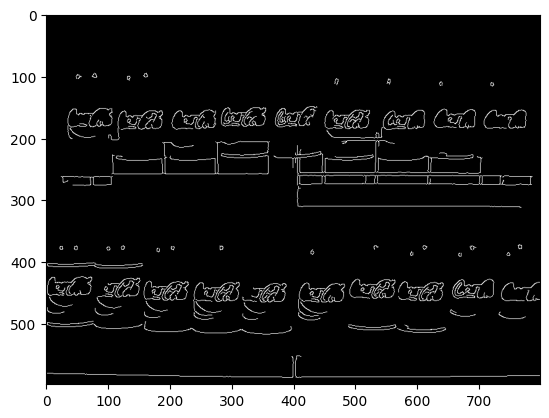

In [17]:
plt.imshow(preprocess(coca_multi, (5,5), sigma=2, thresh_1= 150, thresh_2=400) , cmap= 'gray')

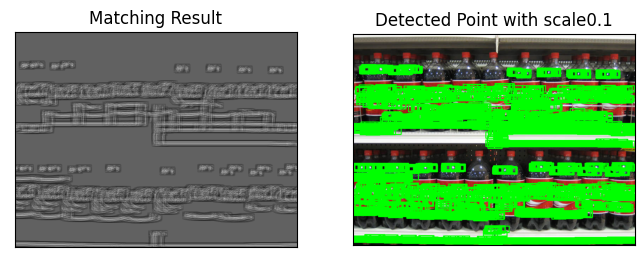

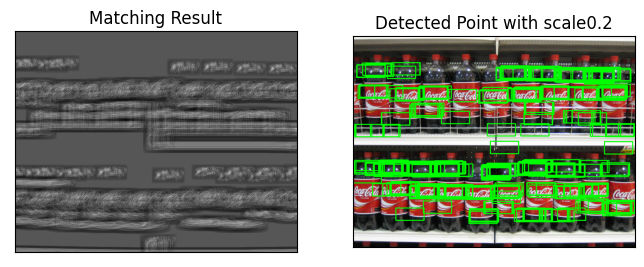

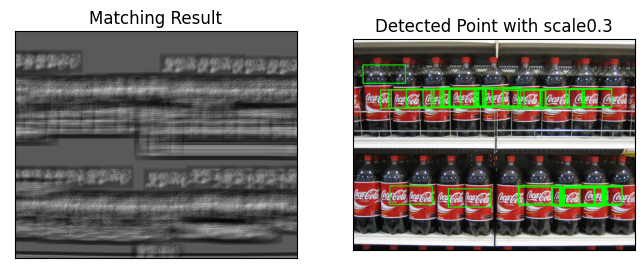

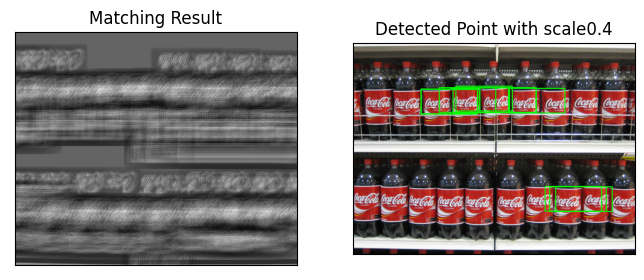

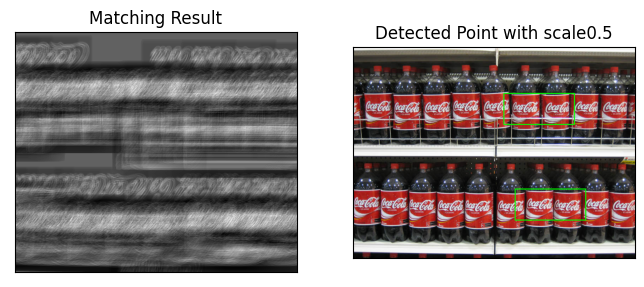

In [18]:
custom_template_matcher_multiple(coca_multi,pattern_canny,0.1,'cv.TM_CCOEFF_NORMED',thresholds=(150,400),scales= np.linspace(0.1,2,20), figsize=(8,4))

Vease que el algoritmo con escala 0.3 logra detectar la mayoria de los objetos de interes

## Parte III
(2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

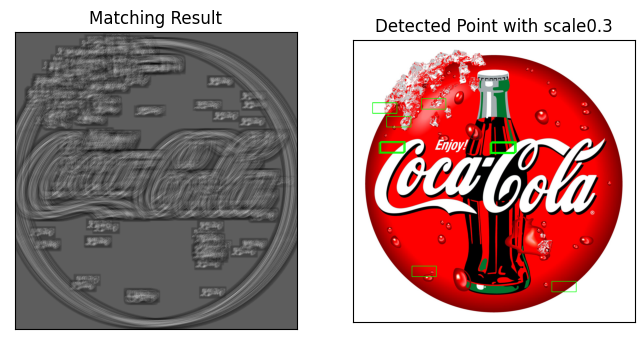

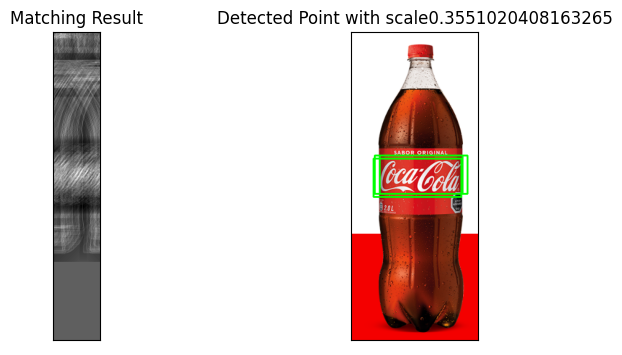

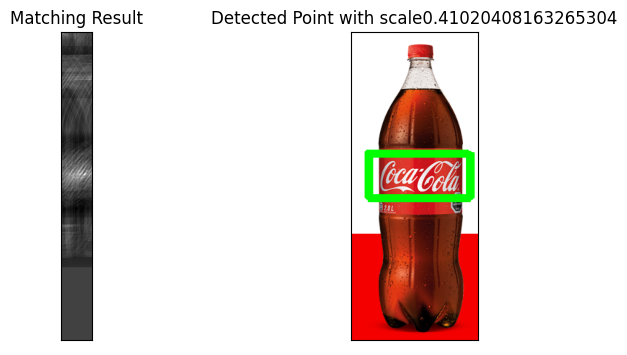

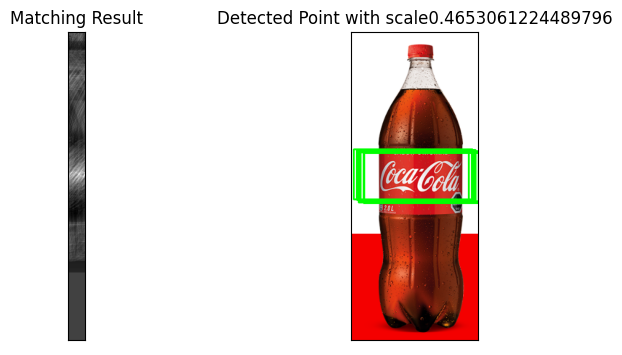

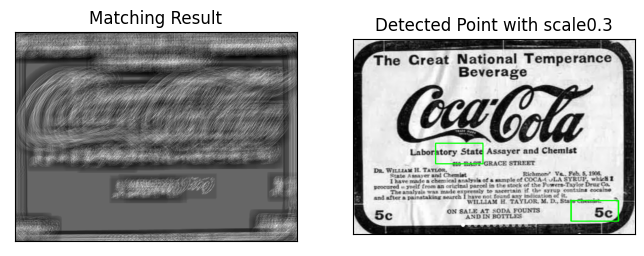

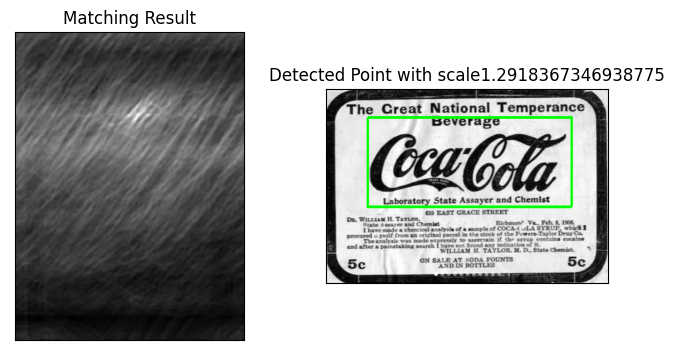

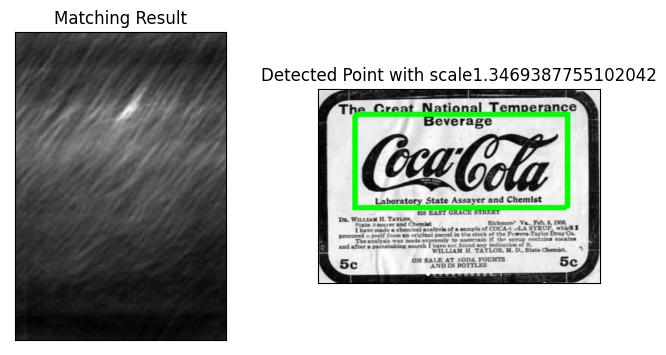

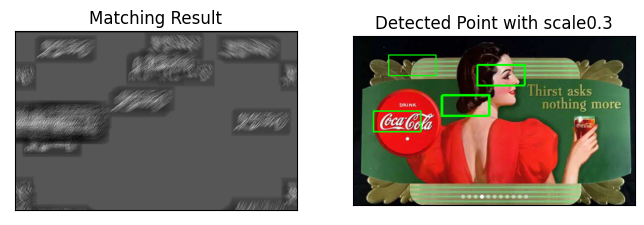

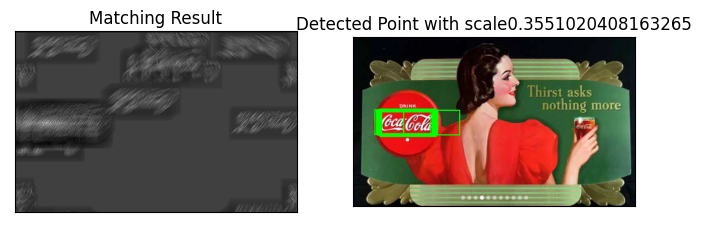

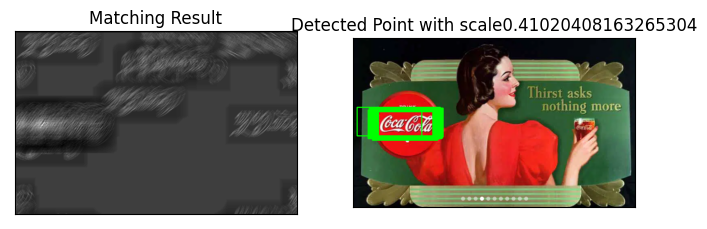

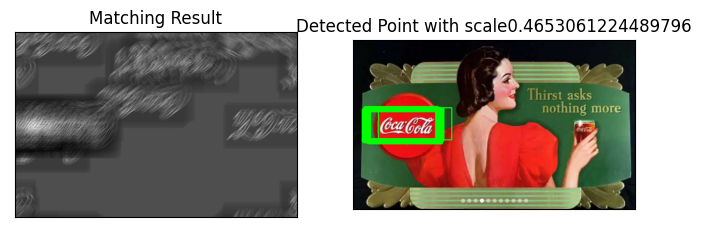

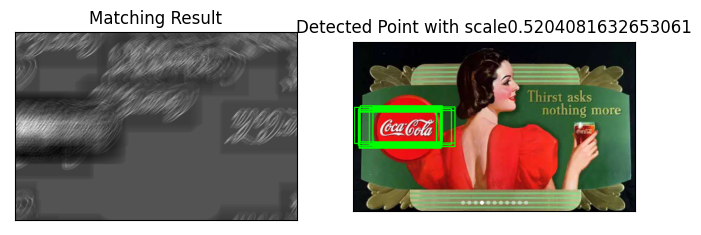

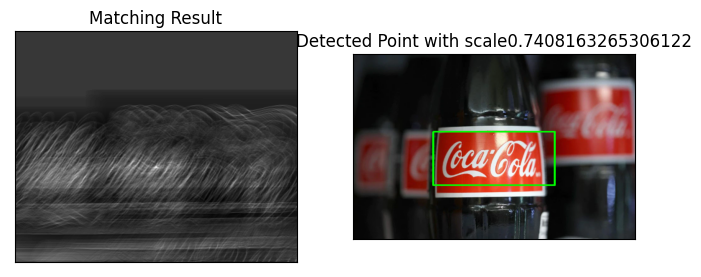

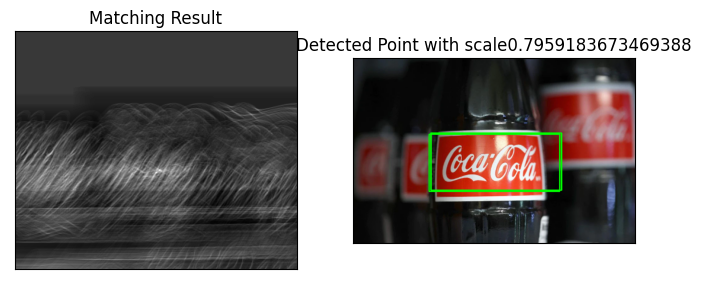

In [19]:
for logo in logos:
    custom_template_matcher_multiple(logo,pattern_canny,0.1,'cv.TM_CCOEFF_NORMED',thresholds=(300,400),scales= np.linspace(0.3,3,50), figsize=(8,4))